In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pqr

In [3]:
prices = pd.read_csv("./factors/china/close_price.csv", index_col=0, parse_dates=True)
volume = pd.read_csv("./factors/china/trading_volume.csv", index_col=0, parse_dates=True)
pe = pd.read_csv("./factors/china/pe.csv", index_col=0, parse_dates=True)

prices, volume, pe = pqr.utils.replace_with_nan(prices, volume, pe, to_replace=0)

# первые наблюдения (с 1973 по ~1991) состоят просто из нанов, удаляем их
for df in prices, volume, pe:
    df.dropna(axis=0, how="all", inplace=True)

# Формируем бенчмарк

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 1_000_000)

benchmark = pqr.Benchmark.from_universe(universe)

# Перебор параметров

In [5]:
def dynamic_factor_preprocessor_factory(looking, lag, holding):
    return [
        pqr.Filter(universe.mask),
        pqr.LookBackPctChange(looking),
        pqr.Lag(lag),
        pqr.Hold(holding)
    ]


def mean_factor_preprocessor_factory(looking, lag, holding):
    return [
        pqr.Filter(universe.mask),
        pqr.LookBackMean(looking),
        pqr.Lag(lag),
        pqr.Hold(holding)
    ]

fm = pqr.fm.FactorModel(
    picking_strategies=pqr.fm.split_quantiles(3),
    allocation_strategy=pqr.EqualWeights(),
    add_wml=True
)

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


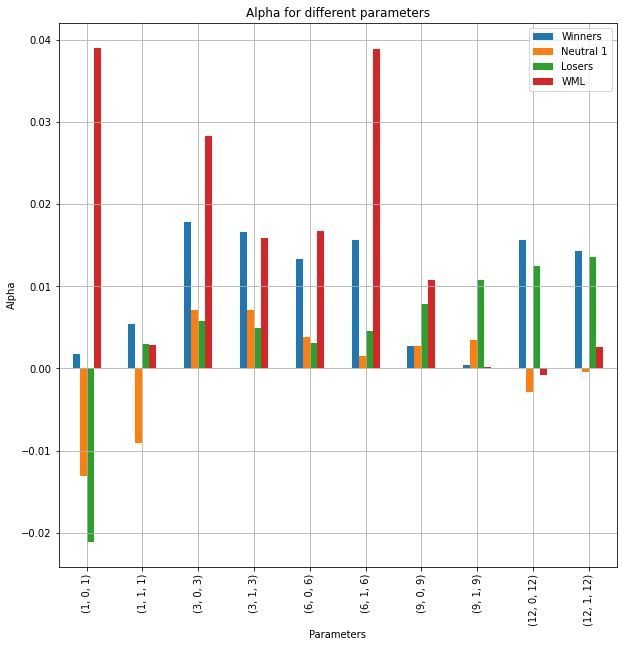

In [6]:
param_grid_mom = {
    "(1, 0, 1)": dynamic_factor_preprocessor_factory(1, 0, 1),
    "(1, 1, 1)": dynamic_factor_preprocessor_factory(1, 1, 1),
    "(3, 0, 3)": dynamic_factor_preprocessor_factory(3, 0, 3),
    "(3, 1, 3)": dynamic_factor_preprocessor_factory(3, 1, 3),
    "(6, 0, 6)": dynamic_factor_preprocessor_factory(6, 0, 6),
    "(6, 1, 6)": dynamic_factor_preprocessor_factory(6, 1, 6),
    "(9, 0, 9)": dynamic_factor_preprocessor_factory(9, 0, 9),
    "(9, 1, 9)": dynamic_factor_preprocessor_factory(9, 1, 9),
    "(12, 0, 12)": dynamic_factor_preprocessor_factory(12, 0, 12),
    "(12, 1, 12)": dynamic_factor_preprocessor_factory(12, 1, 12),
}

mom_raw = pqr.Factor(prices, better="more")

gs_mom = pqr.fm.GridSearch(
    factor_preprocessors=param_grid_mom,
    factor_model=fm
)

gs_mom(
    factor=mom_raw,
    universe=universe,
    target=pqr.metrics.Alpha(benchmark)
).plot.bar(figsize=(10, 10))

plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha")
plt.grid();

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


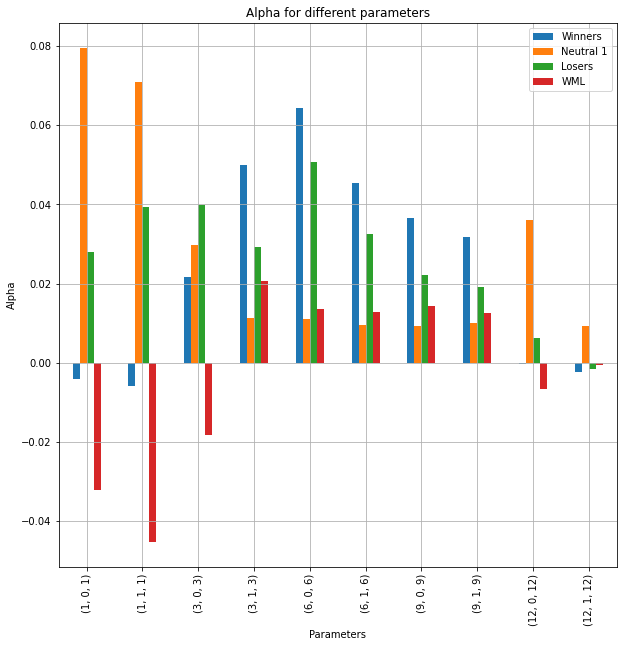

In [7]:
param_grid_value = {
    "(1, 0, 1)": mean_factor_preprocessor_factory(1, 0, 1),
    "(1, 1, 1)": mean_factor_preprocessor_factory(1, 1, 1),
    "(3, 0, 3)": mean_factor_preprocessor_factory(3, 0, 3),
    "(3, 1, 3)": mean_factor_preprocessor_factory(3, 1, 3),
    "(6, 0, 6)": mean_factor_preprocessor_factory(6, 0, 6),
    "(6, 1, 6)": mean_factor_preprocessor_factory(6, 1, 6),
    "(9, 0, 9)": mean_factor_preprocessor_factory(9, 0, 9),
    "(9, 1, 9)": mean_factor_preprocessor_factory(9, 1, 9),
    "(12, 0, 12)": mean_factor_preprocessor_factory(12, 0, 12),
    "(12, 1, 12)": mean_factor_preprocessor_factory(12, 1, 12),
}

value_raw = pqr.Factor(pe, better="more")

gs_value = pqr.fm.GridSearch(
    factor_preprocessors=param_grid_value,
    factor_model=fm
)

gs_value(
    factor=value_raw,
    universe=universe,
    target=pqr.metrics.Alpha(benchmark)
).plot.bar(figsize=(10, 10))

plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha")
plt.grid();

По альфе лучшей моментум стратегией с точки зрения WML-портфеля оказалась стратегия (1, 0, 1), т.е. краткосрочный моментум. А среди value-стратегий лучшими параметрами стали (3, 1, 3), т.е. среднесрочный фактор стоимости. Рассмотрим их поподробнее.

In [8]:
best_mom = pqr.Factor(
    prices,
    better="more",
    preprocessor=dynamic_factor_preprocessor_factory(1, 0, 1)
)
best_value = pqr.Factor(
    pe,
    better="less",
    preprocessor=mean_factor_preprocessor_factory(3, 0, 3)
)

portfolios_mom = fm(best_mom, universe)
portfolios_value = fm(best_value, universe)

# Аналитика

### Ликбез по дашбордам

Дашборд состоит из 2 видов объектов: графики и таблицы. Что график, что таблица имеют единый интерфейс: принимают на вход последовательность (список) портфелей (pqr.Portfolio), ничего не возвращают, но рисуют график (через matplotlib и plt.show) или таблицу (через Ipython.display). Дашборд может содержать любое количество графиков и таблиц в любом порядке.

Непосредственно сами графики и таблицы строятся над конкретными метриками. Различие состоит в том, что таблица строится на основе нескольких числовых метрик, а график - на основе одной timeseries-метрики. С точки зрения интерфейсов числовые (numeric) и timeseries-метрики очень похожи: при вызове считается сырая метрика, не переведенная ни в  какие единицы, но также имеется метод `fancy`, который возвращает "красивый" результат метрики (например, переводит в проценты), также каждая метрика имеет `fancy_name` - красивое имя для таблицы/графика. НО: для числовой метрики результат вызова - число (обычно float) или namedtuple (для некоторых метрик, которые имеют флаг `statistics`), результат `fancy` - строка с округлением до 2 знаков после запятой; а для timeseries-метрики - результат вызова - pd.Series типа float, результат `fancy` - переведенный в проценты, если требуется, pd.Series типа float.

Попробуем теорию на практике.

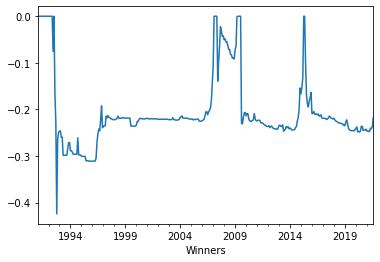

In [9]:
# нарисуем underwater график, который по сути просто считает просадку портфеля во времени
dd = pqr.metrics.Drawdown()
dd(portfolios_mom[0]).plot();

Получилось неплохо, если дописать еще 5-10 строчек, можно получить красивый график, но если захотим отобразить сразу несколько портфелей для сравнения, то надо добавить еще цикл, внимательно проследить за тем, чтобы не зажевало исходную точку. Если надо добавить бенчмарк, то надо проследить, чтобы бенчмарк начинался с начала нашего инвестирования и т.д. 

Чтобы это все не делать руками, воспользуемся графиком из библиотеки.

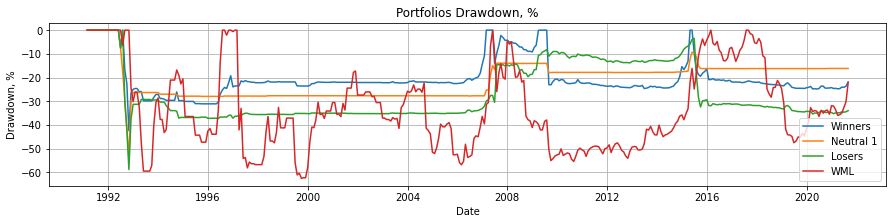

In [10]:
underwater = pqr.dash.Graph(metric=dd, figsize=(15, 3))

underwater(portfolios_mom)

Теперь займемся таблицей.

In [11]:
mini_table = pqr.dash.Table(
    pqr.metrics.SharpeRatio(rf=0),
    pqr.metrics.MeanReturn(statistics=True, annualizer=1), # средняя месячная дох-ть, т.к. аннуалайзер=1
    pqr.metrics.Volatility(annualizer=1), # средняя месячная вол-ть, т.к. аннуалайзер=1
    
    pqr.metrics.MeanExcessReturn(benchmark, statistics=True, annualizer=12),
    pqr.metrics.Alpha(benchmark, statistics=True, annualizer=12),
    pqr.metrics.Beta(benchmark, statistics=False),
)

In [12]:
mini_table(portfolios_mom)

,Winners,Neutral 1,Losers,WML
Sharpe Ratio,0.19,-0.00,-0.00,0.19
"Mean Return, %",0.22 (1.06),-0.00 (-0.01),-0.00 (-0.02),0.44 (1.03)
"Volatility, %",3.91,3.26,4.20,8.13
"Mean Excess Return, %",-10.36 (1.06),-12.97 (-0.01),-13.00 (-0.02),-7.70 (1.03)
"Alpha, %",0.17 (0.08),-1.31 (-0.67),-2.11 (-0.88),3.91 (0.77)
Beta,0.19,0.10,0.16,0.10


После этого объединим все в 1 дашборд, добавив предварительно лог-график для накопленной доходности в сравнении с бенчмарком.

In [13]:
dash = pqr.dash.Dashboard(
    pqr.dash.Graph(metric=pqr.metrics.CompoundedReturns(), log_scale=True, benchmark=benchmark, figsize=(15, 5)),
    underwater,
    mini_table
)

Все готово: отобразим результаты по лучшим стратегиям.

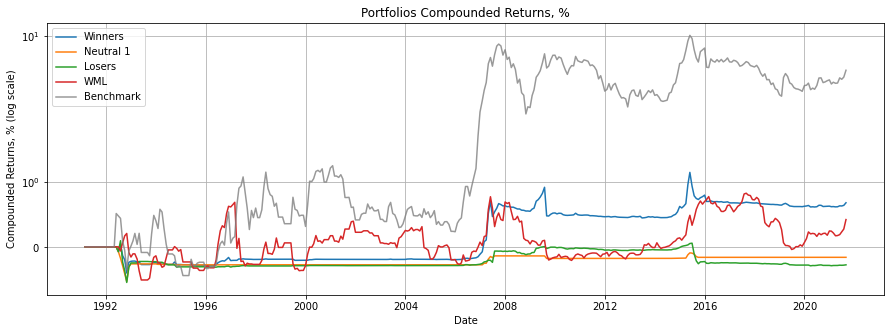

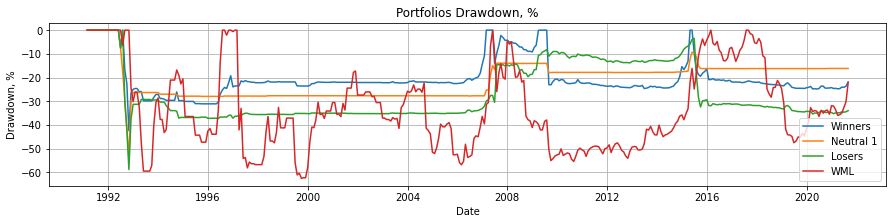

,Winners,Neutral 1,Losers,WML
Sharpe Ratio,0.19,-0.00,-0.00,0.19
"Mean Return, %",0.22 (1.06),-0.00 (-0.01),-0.00 (-0.02),0.44 (1.03)
"Volatility, %",3.91,3.26,4.20,8.13
"Mean Excess Return, %",-10.36 (1.06),-12.97 (-0.01),-13.00 (-0.02),-7.70 (1.03)
"Alpha, %",0.17 (0.08),-1.31 (-0.67),-2.11 (-0.88),3.91 (0.77)
Beta,0.19,0.10,0.16,0.10


In [14]:
dash(portfolios_mom)

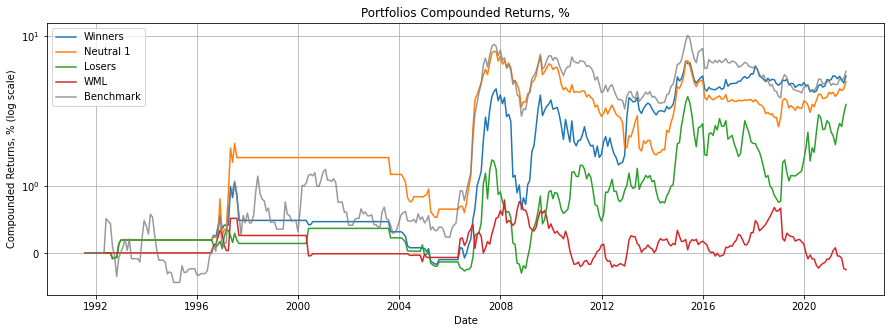

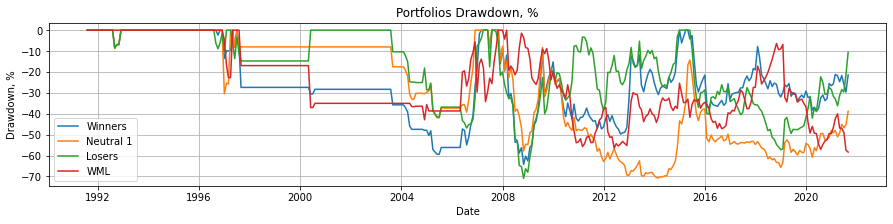

,Winners,Neutral 1,Losers,WML
Sharpe Ratio,0.35,0.33,0.29,0.07
"Mean Return, %",0.75** (1.90),0.75** (1.80),0.62* (1.60),0.13 (0.37)
"Volatility, %",7.54,7.94,7.42,6.50
"Mean Excess Return, %",-4.10** (1.90),-4.12** (1.80),-5.63* (1.60),-11.59 (0.37)
"Alpha, %",3.98 (1.01),3.23 (0.82),2.43 (0.63),1.56 (0.38)
Beta,0.38,0.44,0.39,-0.00


In [15]:
dash(portfolios_value)

P.S.: Бенчмарк имеет подозрительно высокий скачок по доходности в ~2008 году, скорее всего из-за этого у наших стратегий такие низкие беты и высокие альфы, хотя excess return ниже нуля. Ну и фильтр по объему торгов, видимо, оказался очень жестоким: на некоторых промежутках вообще не идут торги.